In [13]:
from IPython.display import Image
import numpy as np
import pymc3 as pm
import seaborn as sns
import theano as th
import theano.tensor as tt

import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import reduce

from plotutils import addtxt
mpl.style.use(['./scripts/theme_bw.mplstyle', './scripts/presentation.mplstyle'])

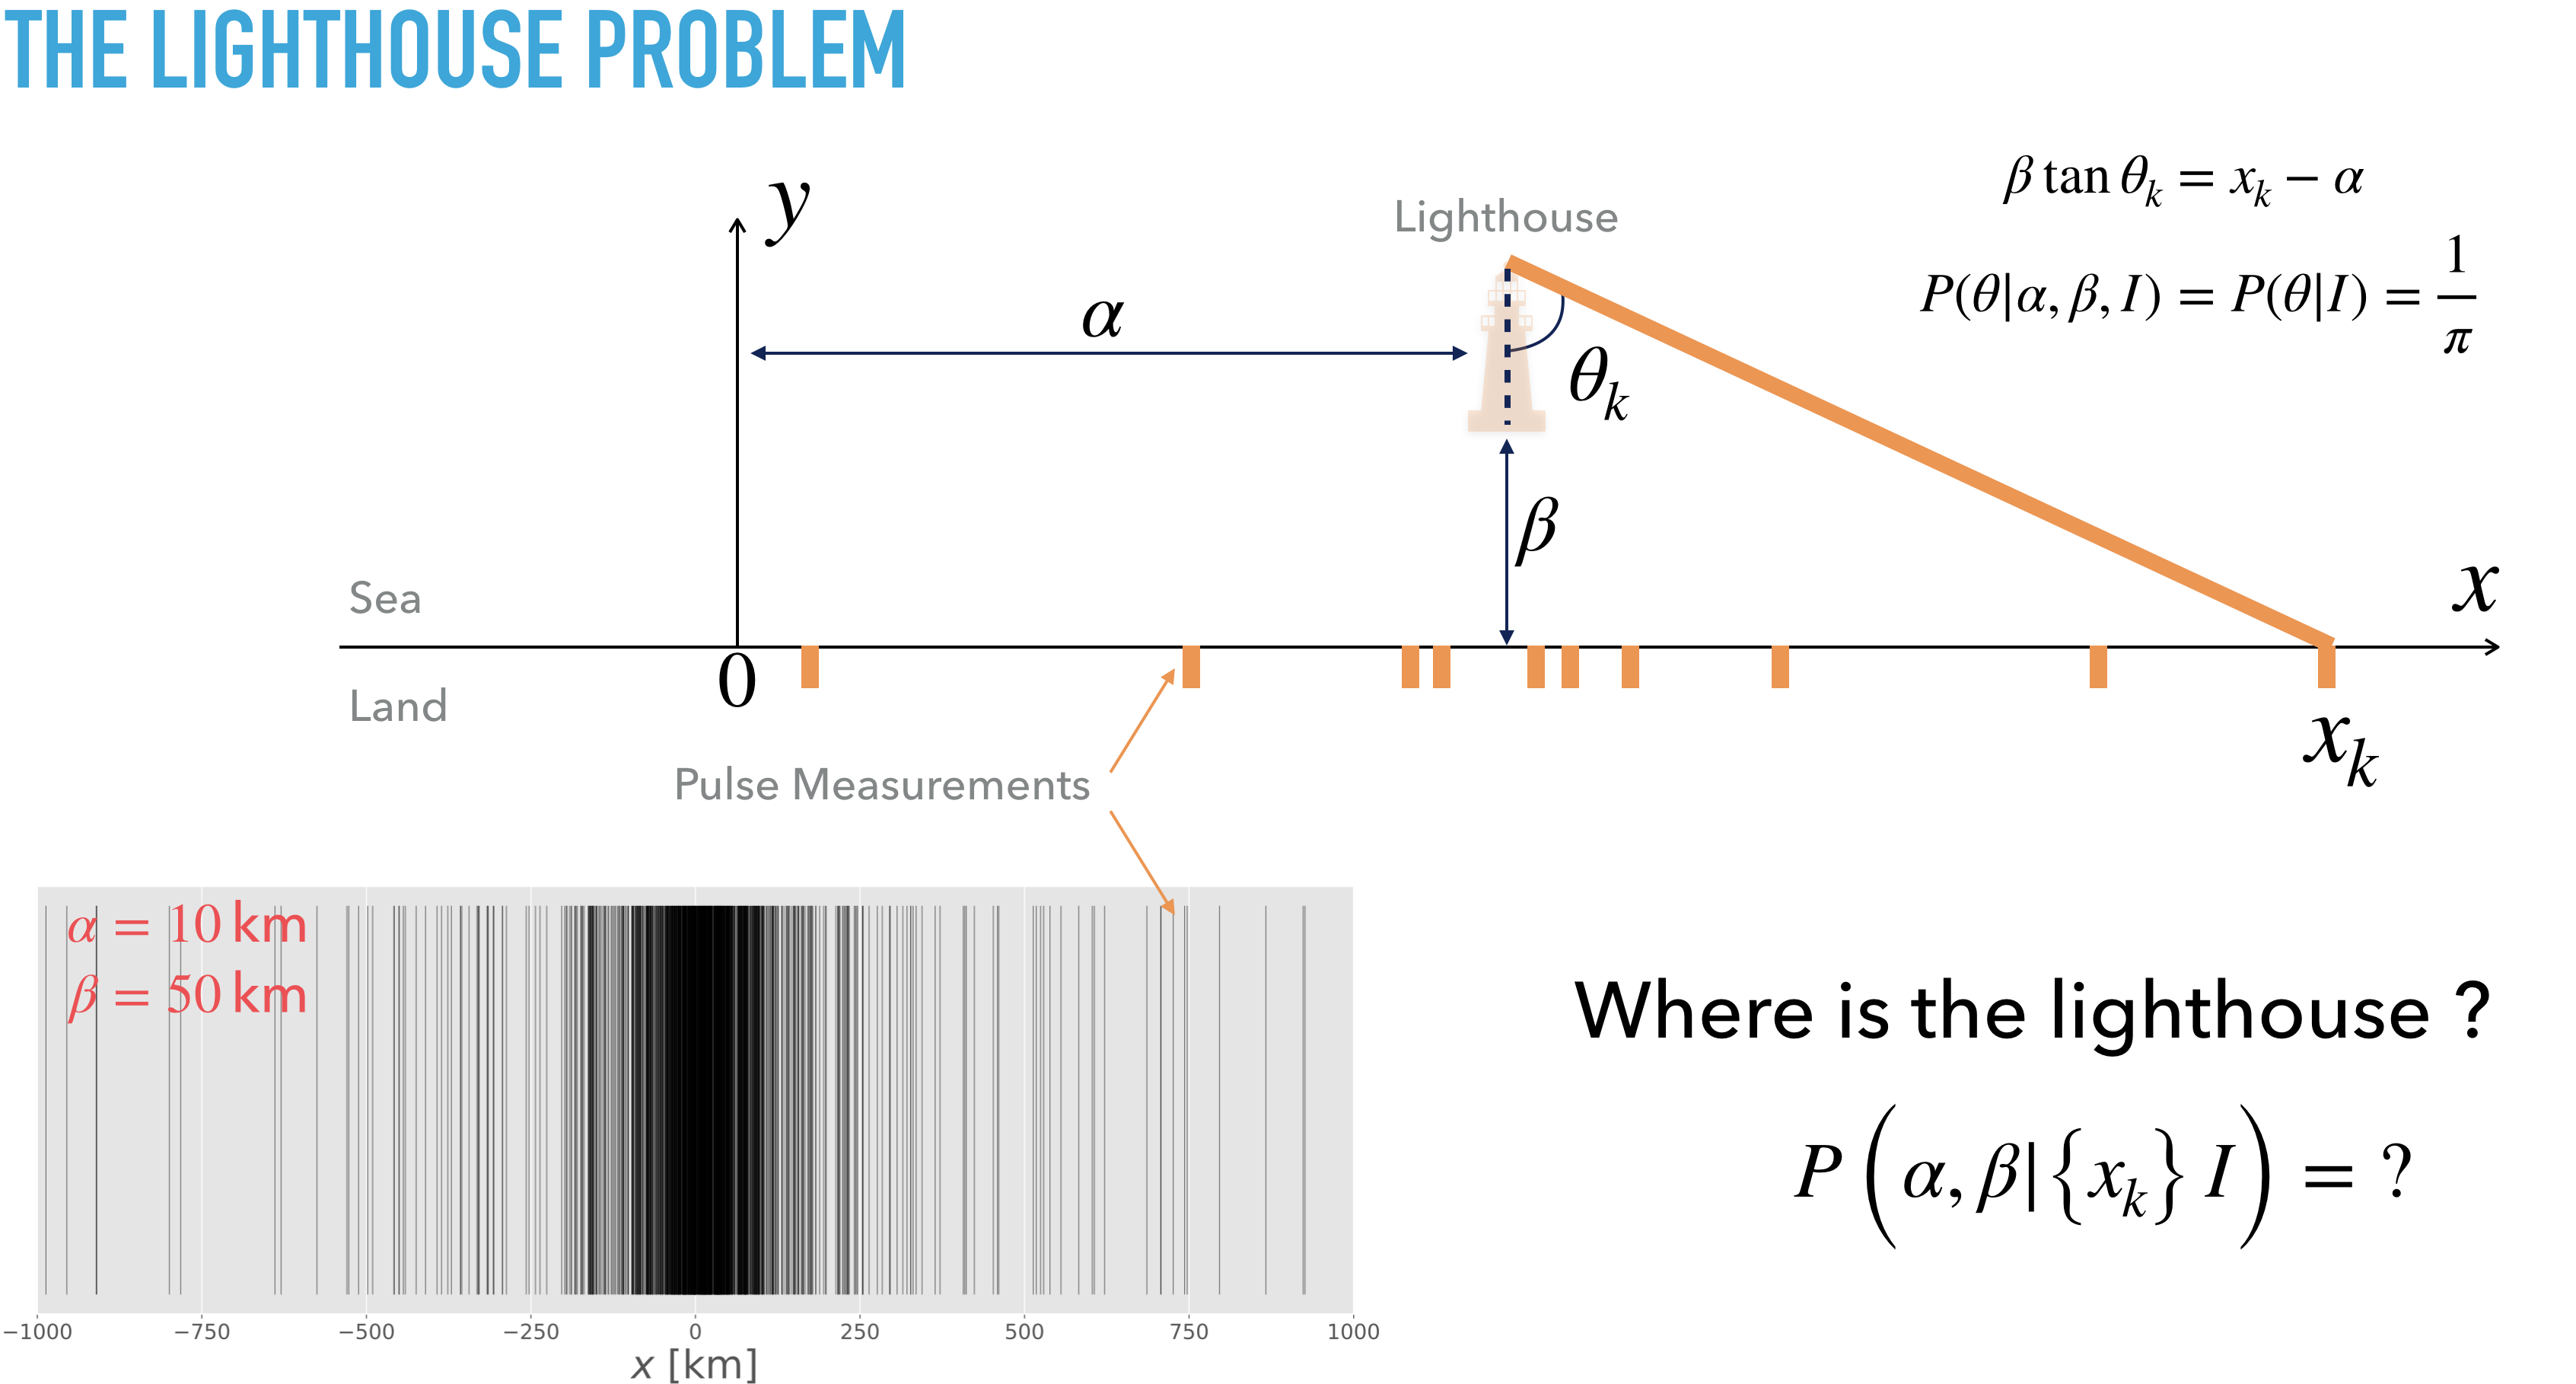

In [2]:
Image(filename='./images/LigthHouse.png') 

Statement: A lighthouse is known to be emmitting pulses in random intervals.

If the pulses are (all) intercepted on the beach, we have the positions ${x_k}$, but not the angles. Where is the lighthouse?

From Bayes' theorem we have
\begin{align}
P(\alpha, \beta \lvert \{x_k\}, I) &= \frac{P(\alpha, \beta \lvert I) P(\{x_k\}\lvert \alpha, \beta, I)}{P(\{x_k\} \lvert I)} \\
&\propto P(\alpha, \beta\lvert I) P(\{x_k\} | \alpha, \beta, I) \\
&\propto P(\alpha\lvert I) P(\beta \lvert I) P(\{x_k\} \lvert \alpha, \beta, I)
\end{align}

We asign a uniform prior on the angles $\theta_k$, and peform a change of variables to derive the corresponding prior on the positions along the beach $x_k$
\begin{align}
P(x_k\lvert \alpha, \beta, I) &= P(\theta_k \lvert \alpha, \beta, I) \left\lvert\frac{\partial\theta_k}{\partial x_k}\right\lvert \\
&= \frac{1}{\pi} \frac{\beta}{\beta^2 + \left(x - \alpha\right)^2}
\end{align}

Note that the prior turns out to be given by a Caucy distribution
https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Cauchy

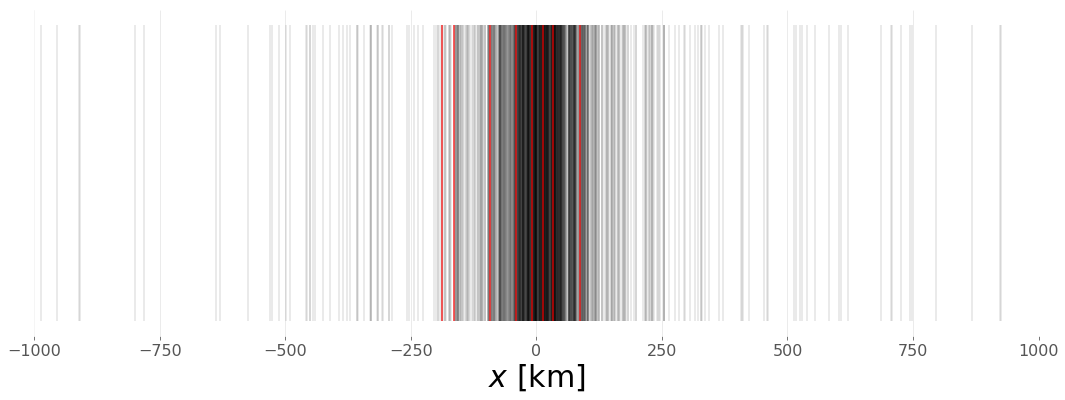

In [3]:
np.random.seed(911)
αtrue, βtrue = 10.0, 50.0

θsample = np.random.uniform(low=-np.pi/2, high=np.pi/2, size=2**10)
xsample = αtrue + βtrue*np.tan(θsample)

fig, ax = plt.subplots(figsize=(18,6))
ax.vlines(xsample, 0.0, 1, alpha=0.8, lw=0.2)
ax.vlines(xsample[:2**3], 0.0, 1, alpha=0.6, lw=2, color='red')
ax.vlines(xsample[2**3:2**6], 0.0, 1, alhpa=0.6, lw=2, color='blue')
ax.set_xlim(-1e3, 1e3)
ax.set_xlabel(r'$x$ [km]', fontsize=30)
ax.set_yticks([])
plt.show()

In [7]:
traces = []
for n in range(1,11):
    with pm.Model() as model:
        α    = pm.Uniform('α', lower=np.min(xsample), upper=np.max(xsample))
        logβ = pm.Uniform('logβ', lower=-10, upper=5)
        β    = pm.Deterministic('β', tt.exp(logβ))
        x    = pm.Cauchy('x', α, β, observed=xsample[:2**n])
        traces.append(pm.sample(10000, tune=15000, progressbar=True))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logβ, α]
Sampling 2 chains: 100%|██████████| 50000/50000 [00:38<00:00, 1307.66draws/s]
The acceptance probability does not match the target. It is 0.7051950064336986, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5523469046643558, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logβ, α]
Sampling 2 chains: 100%|██████████| 50000/50000 [00:28<00:00, 1744.16draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 j

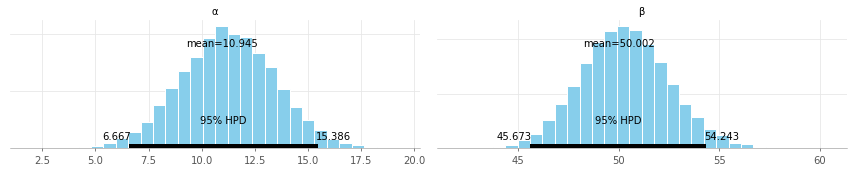

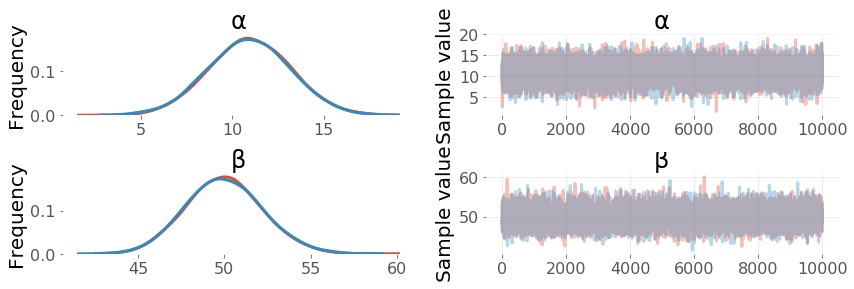

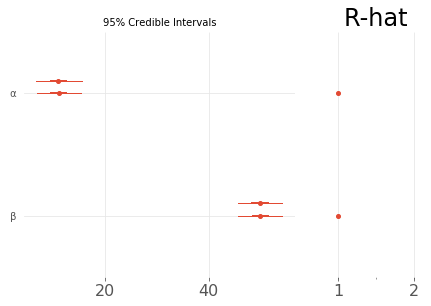

In [10]:
for trace in traces[-1:]:
    pm.plot_posterior(trace, varnames=['α', 'β']); plt.show()
    pm.traceplot(trace, varnames=['α', 'β']); plt.show()
    pm.forestplot(trace, varnames=['α', 'β']); plt.show()

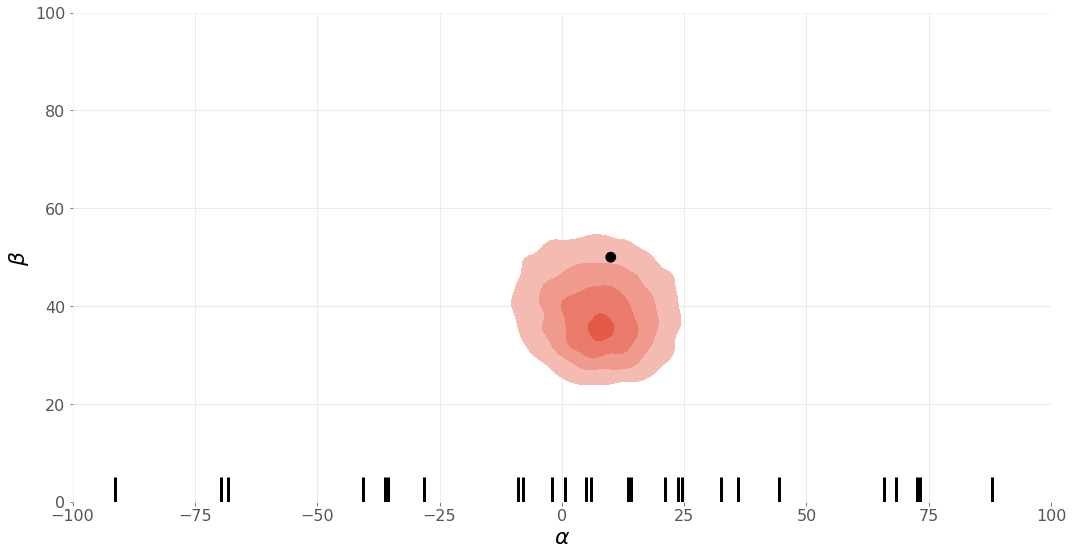

In [28]:
fig, ax = plt.subplots(figsize=(18,9))
n     = 4
trace = traces[n]
raw   = xsample[:2**(n+1)]

sns.kdeplot(trace['α'], trace['β'], shade=True, shade_lowest=False, n_levels=4,ax =ax)
ax.vlines(raw[np.abs(raw) < 100], 0, 5)

ax.add_patch(plt.Circle((αtrue, βtrue), 1,  color='k'))
ax.set_xlim(-100,100); ax.set_ylim(0, 100)
ax.set_aspect('equal')
ax.set_xlabel(r'$\alpha$', fontsize=22); ax.set_ylabel(r'$\beta$', fontsize=22)
plt.show()

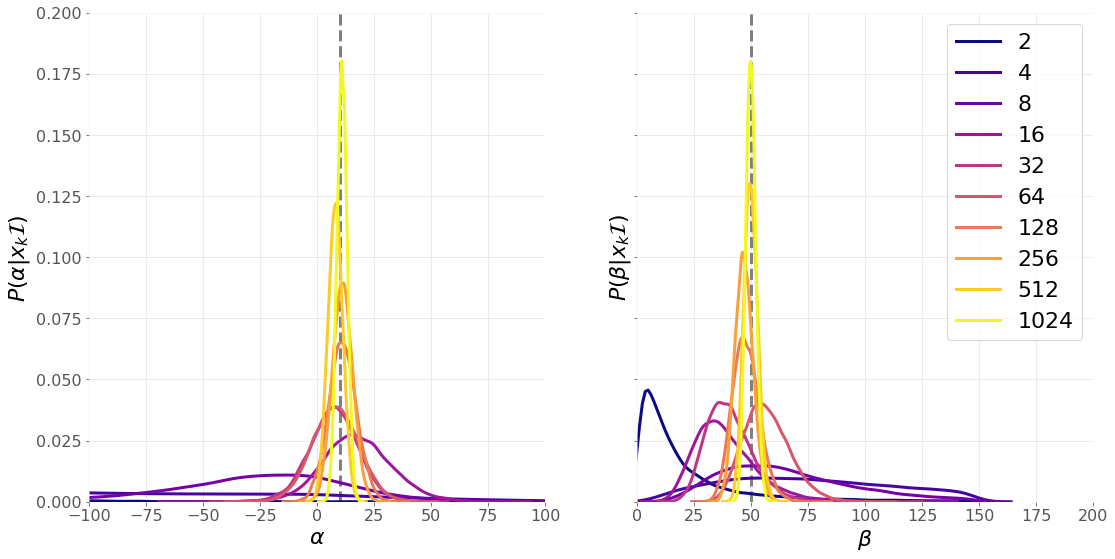

In [22]:
fig, [ax,bx] = plt.subplots(figsize=(18,9), ncols=2, sharey=True)
colors = [mpl.colors.rgb2hex(c) for c in mpl.cm.plasma(np.linspace(0,1,num=len(traces)))]
for trace,n,c in zip(traces, range(len(traces)), colors):
    sns.distplot(trace['α'], color=c, hist=False, ax=ax)
    sns.distplot(trace['β'], color=c, hist=False, ax=bx, label=f'{2**(n+1)}')
for xx,lx,ly in zip([ax,bx], [r'$\alpha$', r'$\beta$'], [r'$P(\alpha | {x_k} \mathcal{I})$', r'$P(\beta | {x_k} \mathcal{I})$']):
    xx.set_xlabel(lx, fontsize=22)
    xx.set_ylabel(ly, fontsize=22)
bx.legend(fontsize=22)
ax.vlines(αtrue, 0.0, 0.2, linestyles='--', color='gray')
bx.vlines(βtrue, 0.0, 0.2, linestyles='--', color='gray')
ax.set_xlim(-100, 100); bx.set_xlim(0, 200); ax.set_ylim(0, 0.2);